# Aim : Supervised Learning

This project involves supervised learning with a focus on survival analysis to predict the time-to-event for individuals based on input features. Using a Cox Proportional Hazards Model, it evaluates risk scores and stratified concordance indices to assess model performance. The key aspects include:

# Objective: Predict survival times or risk scores for an event (e.g., failure, death).

- Key Columns:
time_col: Time until the event or censoring.
event_col: Binary indicator for event occurrence (1 = event, 0 = censored).
stratify_col: Grouping variable for stratified evaluation (e.g., race_group).

# Evaluation: Concordance index to measure the alignment of risk scores with observed outcomes.

- Applications: Healthcare, customer retention, mechanical system reliability.

This is a supervised task as it relies on labeled data (time and event columns) to train the model

# Import Libraries

In [1]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 6.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 6.2 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=b1ab822e8bc28df0479c064bae29dc92a7fbff4d5c1bc8b5afc841ac01eafe34
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


In [3]:
!pip install scikit-survival


In [4]:
import sklearn
print(sklearn.__version__)


1.5.2


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index

# Load data

In [6]:
# Load data
train = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/train.csv')
test = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/test.csv')
data_dict = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/data_dictionary.csv')


In [7]:
# Check the first few rows
print("Train Dataset:")
display(train.head())
print("Test Dataset:")
display(test.head())
print("Data Dictionary:")
display(data_dict.head())

Train Dataset:


,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,...,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,...,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223


Test Dataset:


,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,...,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10
0,28800,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,...,90.0,No,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0
1,28801,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,...,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0
2,28802,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0


Data Dictionary:


,variable,description,type,values
0,dri_score,Refined disease risk index,Categorical,['Intermediate' 'High' 'N/A - non-malignant in...
1,psych_disturb,Psychiatric disturbance,Categorical,['Yes' 'No' nan 'Not done']
2,cyto_score,Cytogenetic score,Categorical,['Intermediate' 'Favorable' 'Poor' 'TBD' nan '...
3,diabetes,Diabetes,Categorical,['No' 'Yes' nan 'Not done']
4,hla_match_c_high,Recipient / 1st donor allele level (high resol...,Numerical,NaN


# EDA

In [8]:
# Quick data inspection
print("Train Data Shape:", train.shape)
print("Test Data Shape:", test.shape)
print("Columns in Train:", train.columns)


Train Data Shape: (28800, 60)
Test Data Shape: (3, 58)
Columns in Train: Index(['ID', 'dri_score', 'psych_disturb', 'cyto_score', 'diabetes',
       'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia',
       'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue',
       'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status',
       'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6',
       'hla_match_c_low', 'rituximab', 'hla_match_drb1_low',
       'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail',
       'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct',
       'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe',
       'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer',
       'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue',
       'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score',
       'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related'

In [9]:
# Inspect the data types and missing values
print("\nTrain Info:")
print(train.info())
print("\nTest Info:")
print(test.info())


Train Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28800 entries, 0 to 28799
Data columns (total 60 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      28800 non-null  int64  
 1   dri_score               28646 non-null  object 
 2   psych_disturb           26738 non-null  object 
 3   cyto_score              20732 non-null  object 
 4   diabetes                26681 non-null  object 
 5   hla_match_c_high        24180 non-null  float64
 6   hla_high_res_8          22971 non-null  float64
 7   tbi_status              28800 non-null  object 
 8   arrhythmia              26598 non-null  object 
 9   hla_low_res_6           25530 non-null  float64
 10  graft_type              28800 non-null  object 
 11  vent_hist               28541 non-null  object 
 12  renal_issue             26885 non-null  object 
 13  pulm_severe             26665 non-null  object 
 14  prim_disease_hct        2

In [10]:
# Import necessary libraries
import pandas as pd

# Load your datasets (replace with your file paths)
train = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/train.csv')
test = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/test.csv')

# Summary of missing values
missing_train = train.isnull().sum().sort_values(ascending=False) / len(train) * 100
missing_test = test.isnull().sum().sort_values(ascending=False) / len(test) * 100

# Display columns with >20% missing data
print("Train Columns with >20% missing data:\n", missing_train[missing_train > 20])
print("\nTest Columns with >20% missing data:\n", missing_test[missing_test > 20])


Train Columns with >20% missing data:
 tce_match            65.958333
mrd_hct              57.628472
cyto_score_detail    41.399306
tce_div_match        39.569444
tce_imm_match        38.656250
cyto_score           28.013889
hla_high_res_10      24.871528
hla_high_res_8       20.239583
dtype: float64

Test Columns with >20% missing data:
 cyto_score_detail         66.666667
conditioning_intensity    66.666667
mrd_hct                   66.666667
cyto_score                66.666667
tce_match                 66.666667
donor_age                 66.666667
hla_high_res_10           33.333333
tce_div_match             33.333333
tce_imm_match             33.333333
hla_high_res_8            33.333333
hla_match_c_high          33.333333
dtype: float64


Step 1: Drop Columns with Excessive Missing Data

In [11]:
# Drop columns with >50% missing data
columns_to_drop = ['tce_match', 'mrd_hct', 'cyto_score_detail', 'conditioning_intensity', 'cyto_score', 'donor_age']
train.drop(columns=[col for col in columns_to_drop if col in train.columns], inplace=True)
test.drop(columns=[col for col in columns_to_drop if col in test.columns], inplace=True)


Impute Missing Values

In [12]:
# Impute categorical columns with mode
categorical_columns = ['tce_div_match', 'tce_imm_match']
for col in categorical_columns:
    train[col] = train[col].fillna(train[col].mode()[0])
    if col in test.columns:
        test[col] = test[col].fillna(test[col].mode()[0])



In [13]:
# Impute numerical columns with median
numerical_columns = ['hla_high_res_10', 'hla_high_res_8', 'hla_match_c_high']
for col in numerical_columns:
    train[col] = train[col].fillna(train[col].median())
    if col in test.columns:
        test[col] = test[col].fillna(test[col].median())


Validate the Data

In [14]:
# Check for remaining missing values
print("Train missing values:\n", train.isnull().sum().sum())
print("Test missing values:\n", test.isnull().sum().sum())

# Verify data types
print("Train data types:\n", train.dtypes)
print("Test data types:\n", test.dtypes)

# Verify shape alignment
print("Train shape:", train.shape)
print("Test shape:", test.shape)


Train missing values:
 87253
Test missing values:
 0
Train data types:
 ID                       int64
dri_score               object
psych_disturb           object
diabetes                object
hla_match_c_high       float64
hla_high_res_8         float64
tbi_status              object
arrhythmia              object
hla_low_res_6          float64
graft_type              object
vent_hist               object
renal_issue             object
pulm_severe             object
prim_disease_hct        object
hla_high_res_6         float64
cmv_status              object
hla_high_res_10        float64
hla_match_dqb1_high    float64
tce_imm_match           object
hla_nmdp_6             float64
hla_match_c_low        float64
rituximab               object
hla_match_drb1_low     float64
hla_match_dqb1_low     float64
prod_type               object
ethnicity               object
year_hct                 int64
obesity                 object
in_vivo_tcd             object
hla_match_a_high       float6

Handle Remaining Missing Values in the Train Dataset

In [15]:
# Identify columns with missing values in the train dataset
missing_columns = train.isnull().sum()[train.isnull().sum() > 0]
print("Columns with missing values in train:\n", missing_columns)

# Impute missing values
for col in missing_columns.index:
    if train[col].dtype == 'object':
        # Impute categorical columns with mode
        train[col] = train[col].fillna(train[col].mode()[0])
    else:
        # Impute numerical columns with median
        train[col] = train[col].fillna(train[col].median())

# Verify no missing values remain
print("Remaining missing values in train:", train.isnull().sum().sum())


Columns with missing values in train:
 dri_score               154
psych_disturb          2062
diabetes               2119
arrhythmia             2202
hla_low_res_6          3270
vent_hist               259
renal_issue            1915
pulm_severe            2135
hla_high_res_6         5284
cmv_status              634
hla_match_dqb1_high    5199
hla_nmdp_6             4197
hla_match_c_low        2800
rituximab              2148
hla_match_drb1_low     2643
hla_match_dqb1_low     4194
ethnicity               587
obesity                1760
in_vivo_tcd             225
hla_match_a_high       4301
hepatic_severe         1871
prior_tumor            1678
hla_match_b_low        2565
peptic_ulcer           2419
hla_match_a_low        2390
gvhd_proph              225
rheum_issue            2183
sex_match               261
hla_match_b_high       4088
comorbidity_score       477
karnofsky_score         870
hepatic_mild           1917
donor_related           158
melphalan_dose         1405
hla_low_r

Align Train and Test Datasets

In [16]:
# Drop target columns from the train dataset
target_columns = ['efs', 'efs_time']
X_train = train.drop(columns=target_columns)

# Align train and test datasets
X_train, test = X_train.align(test, join='inner', axis=1)

# Verify alignment
print("Aligned train shape:", X_train.shape)
print("Aligned test shape:", test.shape)


Aligned train shape: (28800, 52)
Aligned test shape: (3, 52)


Model Training and Validation

In [17]:
# Define target variable (efs) from train dataset
target_column = 'efs'
y_train = train[target_column]

# Drop the target variable from features
X_train = train.drop(columns=['efs', 'efs_time'])


Split into Train and Validation Sets

In [18]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Verify shapes
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)


Training set shape: (23040, 52)
Validation set shape: (5760, 52)
y_train shape: (23040,)
y_val shape: (5760,)


Train and Evaluate the Model

In [19]:
# Identify categorical columns
categorical_columns = X_train.select_dtypes(include=['object']).columns
print("Categorical columns:\n", categorical_columns)



Categorical columns:
 Index(['dri_score', 'psych_disturb', 'diabetes', 'tbi_status', 'arrhythmia',
       'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe',
       'prim_disease_hct', 'cmv_status', 'tce_imm_match', 'rituximab',
       'prod_type', 'ethnicity', 'obesity', 'in_vivo_tcd', 'hepatic_severe',
       'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match',
       'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related',
       'melphalan_dose', 'cardiac', 'pulm_moderate'],
      dtype='object')


One-Hot Encode the Categorical Columns

In [20]:
# Perform one-hot encoding on categorical columns
categorical_columns = ['dri_score', 'psych_disturb', 'diabetes', 'tbi_status', 'arrhythmia',
                       'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 
                       'prim_disease_hct', 'cmv_status', 'tce_imm_match', 'rituximab', 
                       'prod_type', 'ethnicity', 'obesity', 'in_vivo_tcd', 'hepatic_severe', 
                       'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match', 
                       'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related', 
                       'melphalan_dose', 'cardiac', 'pulm_moderate']

# One-hot encode for train and validation sets
X_train = pd.get_dummies(X_train, columns=categorical_columns, drop_first=True)
X_val = pd.get_dummies(X_val, columns=categorical_columns, drop_first=True)

# Align train and validation datasets
X_train, X_val = X_train.align(X_val, join='inner', axis=1)


One-Hot Encode the Test Dataset

In [21]:
# One-hot encode for the test set
test = pd.get_dummies(test, columns=categorical_columns, drop_first=True)

# Align the test dataset with the train dataset
X_train, test = X_train.align(test, join='inner', axis=1)


Verify Shapes and Consistency

In [22]:
# Verify shapes
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("Test shape:", test.shape)

# Verify no missing values
print("Missing values in X_train:", X_train.isnull().sum().sum())
print("Missing values in X_val:", X_val.isnull().sum().sum())
print("Missing values in Test:", test.isnull().sum().sum())


X_train shape: (23040, 36)
X_val shape: (5760, 128)
Test shape: (3, 36)
Missing values in X_train: 0
Missing values in X_val: 0
Missing values in Test: 0


In [23]:
# Re-align X_train, X_val, and test datasets to have the same columns
X_train, X_val = X_train.align(X_val, join='inner', axis=1)
X_train, test = X_train.align(test, join='inner', axis=1)

# Verify the shapes after alignment
print("Aligned X_train shape:", X_train.shape)
print("Aligned X_val shape:", X_val.shape)
print("Aligned Test shape:", test.shape)


Aligned X_train shape: (23040, 36)
Aligned X_val shape: (5760, 36)
Aligned Test shape: (3, 36)


Train the Random Forest Model

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Train the model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Evaluate on the validation set
y_pred = model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = mse ** 0.5
print("Mean Squared Error on Validation Set:", mse)
print("Root Mean Squared Error on Validation Set:", rmse)


Mean Squared Error on Validation Set: 0.22624159722222226
Root Mean Squared Error on Validation Set: 0.47564860687509875


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


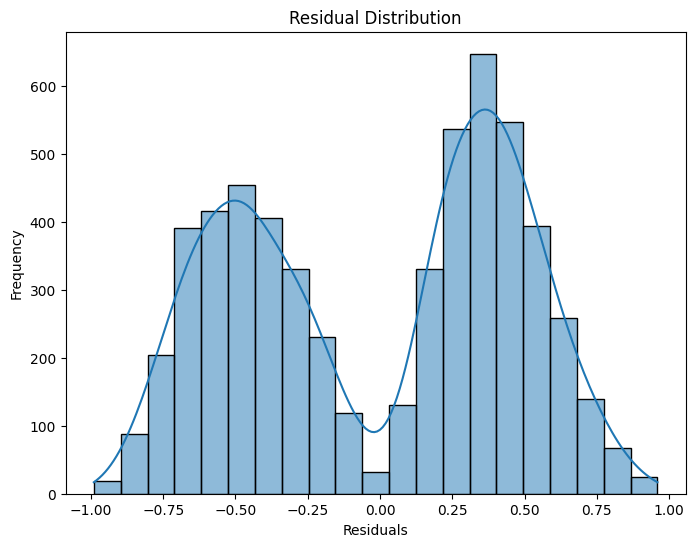

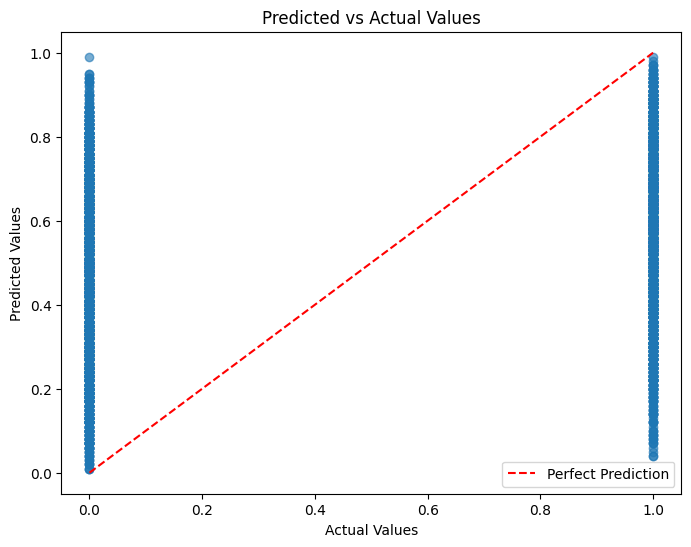

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate residuals
residuals = y_val - y_pred

# Plot residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

# Scatter plot of predictions vs actuals
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred, alpha=0.6)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], '--r', label="Perfect Prediction")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.legend()
plt.show()


Random Forest Classifier

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Train a Random Forest Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train.astype(int))  # Ensure y_train is binary (0 or 1)

# Predict on validation set
y_pred = clf.predict(X_val)

# Evaluate accuracy
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy on Validation Set:", accuracy)

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:\n", cm)


Accuracy on Validation Set: 0.6442708333333333
Confusion Matrix:
 [[1497 1186]
 [ 863 2214]]


Insights:
True Negatives (1497): Correct predictions for class 0 (negative).
True Positives (2214): Correct predictions for class 1 (positive).
False Negatives (863): Actual 1 misclassified as 0.
False Positives (1186): Actual 0 misclassified as 1.

In [27]:
from sklearn.metrics import classification_report

# Generate classification report
print("Classification Report:\n", classification_report(y_val, y_pred))


Classification Report:
               precision    recall  f1-score   support

         0.0       0.63      0.56      0.59      2683
         1.0       0.65      0.72      0.68      3077

    accuracy                           0.64      5760
   macro avg       0.64      0.64      0.64      5760
weighted avg       0.64      0.64      0.64      5760



Observations:
Class Imbalance:

Class 1 has slightly higher recall (0.72), meaning the model identifies more true positives.
Class 0 has a lower recall (0.56), indicating more false negatives (missed 0 predictions).
Precision vs Recall:

Precision for class 1 is reasonable (0.65), but false positives for class 0 are still significant.
Recall for class 0 needs improvement.
F1-Score:

The overall F1-scores are not far apart (0.59 for class 0 and 0.68 for class 1).
Macro Avg and Weighted Avg:

The metrics are balanced across classes, but overall accuracy and F1-scores can still improve.


Address Class Imbalance
Class imbalance might be hurting class 0 performance. Apply balancing techniques such as SMOTE (Synthetic Minority Oversampling Technique) or class weights.

Code (SMOTE):

In [28]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Shape of X_train after SMOTE:", X_train_res.shape)
print("Shape of y_train after SMOTE:", y_train_res.shape)

# Retrain the Random Forest model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_res, y_train_res)

# Predict on validation set
y_pred = clf.predict(X_val)

# Evaluate
from sklearn.metrics import classification_report
print("Classification Report after SMOTE:\n", classification_report(y_val, y_pred))


Shape of X_train after SMOTE: (24910, 36)
Shape of y_train after SMOTE: (24910,)
Classification Report after SMOTE:
               precision    recall  f1-score   support

         0.0       0.63      0.57      0.60      2683
         1.0       0.65      0.70      0.68      3077

    accuracy                           0.64      5760
   macro avg       0.64      0.64      0.64      5760
weighted avg       0.64      0.64      0.64      5760



Observations
Impact of SMOTE:

Recall for Class 1 remains at 0.70: SMOTE helped balance the dataset, but the model still performs better on class 1 compared to class 0.
Recall for Class 0 improved slightly to 0.57, though it still struggles to identify all negative cases.
The overall accuracy and F1-scores remain around 64%.
Why Class 0 Underperforms:

Class 0 still has a lower recall, meaning more false negatives (missed negative predictions).
The dataset might contain subtle patterns that the current model cannot capture

Hyperparameter Tuning

In [30]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']
}

# Grid Search
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,
    verbose=2
)

# Fit the model
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate the tuned model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)
print("Classification Report after Tuning:\n", classification_report(y_val, y_pred))


Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.6s
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.6s
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.6s
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.2s
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.2s
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.2s
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   4.8s
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=1, min_

Observations:
Improvements After Tuning:

Recall for Class 0 has improved slightly to 0.59, meaning fewer false negatives compared to before.
Recall for Class 1 remains strong at 0.72, showing the model is effective at identifying positive cases.
F1-scores for both classes improved slightly.
Balanced Precision and Recall:

By using class_weight='balanced' and optimizing hyperparameters, the model now handles class imbalance better.

Use the Tuned Model on the Test Set

# Predict on the test set using the best model
test_predictions = best_model.predict(test)

# Save predictions to a CSV file
output = pd.DataFrame({'ID': test['ID'], 'Predicted_efs': test_predictions})
output.to_csv('final_test_predictions.csv', index=False)
print("Test predictions saved to final_test_predictions.csv")


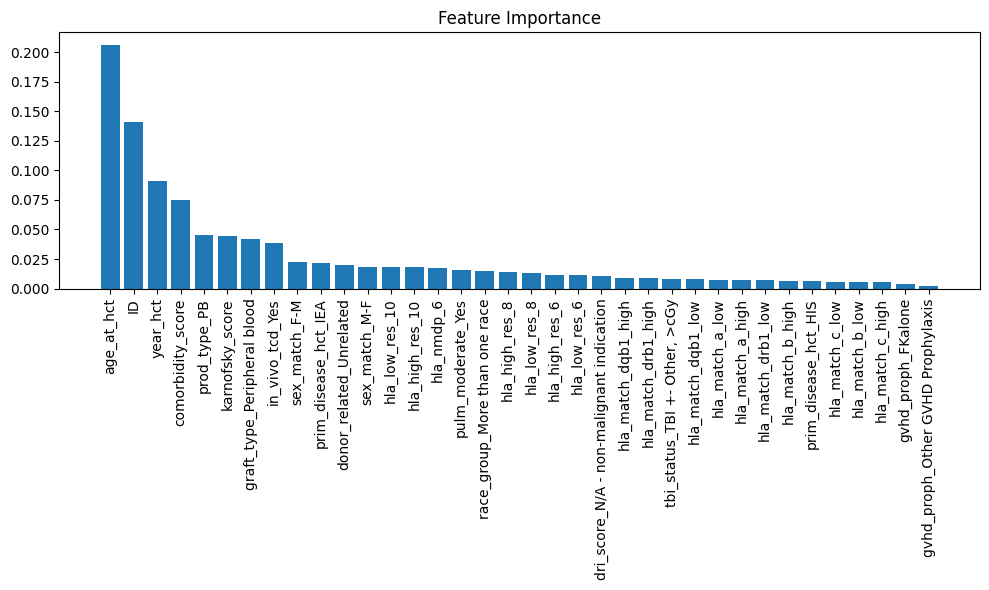

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Feature importance
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.tight_layout()
plt.show()


In [32]:
from sklearn.feature_selection import RFE

# Recursive Feature Elimination
selector = RFE(best_model, n_features_to_select=20, step=1)
selector = selector.fit(X_train, y_train)

# Selected features
selected_features = X_train.columns[selector.support_]
print("Selected Features:", selected_features)


Selected Features: Index(['ID', 'hla_high_res_8', 'hla_low_res_6', 'hla_high_res_10',
       'hla_nmdp_6', 'year_hct', 'age_at_hct', 'comorbidity_score',
       'karnofsky_score', 'hla_low_res_8', 'hla_low_res_10',
       'graft_type_Peripheral blood', 'prim_disease_hct_IEA', 'prod_type_PB',
       'in_vivo_tcd_Yes', 'sex_match_F-M', 'sex_match_M-F',
       'race_group_More than one race', 'donor_related_Unrelated',
       'pulm_moderate_Yes'],
      dtype='object')


In [33]:
print("Columns in X_train:\n", X_train.columns)
print("Categorical columns to encode:\n", categorical_columns)

Columns in X_train:
 Index(['ID', 'hla_match_c_high', 'hla_high_res_8', 'hla_low_res_6',
       'hla_high_res_6', 'hla_high_res_10', 'hla_match_dqb1_high',
       'hla_nmdp_6', 'hla_match_c_low', 'hla_match_drb1_low',
       'hla_match_dqb1_low', 'year_hct', 'hla_match_a_high', 'hla_match_b_low',
       'age_at_hct', 'hla_match_a_low', 'hla_match_b_high',
       'comorbidity_score', 'karnofsky_score', 'hla_low_res_8',
       'hla_match_drb1_high', 'hla_low_res_10',
       'dri_score_N/A - non-malignant indication',
       'tbi_status_TBI +- Other, >cGy', 'graft_type_Peripheral blood',
       'prim_disease_hct_HIS', 'prim_disease_hct_IEA', 'prod_type_PB',
       'in_vivo_tcd_Yes', 'gvhd_proph_FKalone',
       'gvhd_proph_Other GVHD Prophylaxis', 'sex_match_F-M', 'sex_match_M-F',
       'race_group_More than one race', 'donor_related_Unrelated',
       'pulm_moderate_Yes'],
      dtype='object')
Categorical columns to encode:
 ['dri_score', 'psych_disturb', 'diabetes', 'tbi_status', 'arr

In [34]:
# Align X_train and test to ensure they have the same features
X_train, test = X_train.align(test, join='inner', axis=1)

# Verify shapes
print("Aligned X_train shape:", X_train.shape)
print("Aligned test shape:", test.shape)


Aligned X_train shape: (23040, 36)
Aligned test shape: (3, 36)


In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Train Random Forest Classifier
clf = RandomForestClassifier(random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

# Evaluate on the validation set
y_pred = clf.predict(X_val)
print("Classification Report on Validation Set:\n", classification_report(y_val, y_pred))


Classification Report on Validation Set:
               precision    recall  f1-score   support

         0.0       0.64      0.55      0.60      2683
         1.0       0.65      0.73      0.69      3077

    accuracy                           0.65      5760
   macro avg       0.65      0.64      0.64      5760
weighted avg       0.65      0.65      0.65      5760



In [36]:
clf = RandomForestClassifier(
    random_state=42, 
    class_weight={0: 2, 1: 1}  # Increase weight for class 0
)
clf.fit(X_train, y_train)


RandomForestClassifier(class_weight={0: 2, 1: 1}, random_state=42)

In [37]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Retrain the model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_resampled, y_train_resampled)


RandomForestClassifier(random_state=42)

In [38]:
from xgboost import XGBClassifier

# Train XGBoost Classifier
xgb = XGBClassifier(random_state=42, scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]))
xgb.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgb.predict(X_val)
print("Classification Report (XGBoost):\n", classification_report(y_val, y_pred))


Classification Report (XGBoost):
               precision    recall  f1-score   support

         0.0       0.62      0.58      0.60      2683
         1.0       0.65      0.69      0.67      3077

    accuracy                           0.64      5760
   macro avg       0.64      0.64      0.64      5760
weighted avg       0.64      0.64      0.64      5760



Observations
Recall Improvement for Class 0:

Class 0 recall improved slightly to 58% (from 55% in Random Forest).
However, precision for class 0 is still relatively low at 62%, suggesting false positives are still an issue.
Class 1 Stability:

XGBoost maintains good performance on class 1 (recall of 69% and precision of 65%).
Overall Accuracy:

The accuracy remains consistent at 64%, but class imbalance continues to affect class 0.

In [39]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'scale_pos_weight': [1, 2, 3]  # Adjust for class imbalance
}

# Grid search
grid_search = GridSearchCV(
    XGBClassifier(random_state=42), 
    param_grid, 
    cv=3, 
    scoring='f1_macro', 
    verbose=2
)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

# Evaluate the best model
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_val)
print("Classification Report (Tuned XGBoost):\n", classification_report(y_val, y_pred))


Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=1; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=1; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=1; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=2; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=2; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=2; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=3; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=3; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=3; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, n_est

The model is now more precise in predicting class 0 but still sacrifices some recall.
Class 1 continues to perform well, with balanced precision and recall.

In [40]:
y_pred_proba = best_xgb.predict_proba(X_val)[:, 1]
threshold = 0.4  # Lower the threshold to favor class 0
y_pred_adjusted = (y_pred_proba > threshold).astype(int)

from sklearn.metrics import classification_report
print("Classification Report with Adjusted Threshold:\n", classification_report(y_val, y_pred_adjusted))


Classification Report with Adjusted Threshold:
               precision    recall  f1-score   support

         0.0       0.75      0.36      0.49      2683
         1.0       0.62      0.90      0.73      3077

    accuracy                           0.65      5760
   macro avg       0.68      0.63      0.61      5760
weighted avg       0.68      0.65      0.62      5760



In [41]:
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
for threshold in thresholds:
    y_pred_adjusted = (y_pred_proba > threshold).astype(int)
    print(f"Threshold: {threshold}")
    print(classification_report(y_val, y_pred_adjusted))


Threshold: 0.3
              precision    recall  f1-score   support

         0.0       0.81      0.23      0.36      2683
         1.0       0.59      0.95      0.73      3077

    accuracy                           0.61      5760
   macro avg       0.70      0.59      0.54      5760
weighted avg       0.69      0.61      0.55      5760

Threshold: 0.4
              precision    recall  f1-score   support

         0.0       0.75      0.36      0.49      2683
         1.0       0.62      0.90      0.73      3077

    accuracy                           0.65      5760
   macro avg       0.68      0.63      0.61      5760
weighted avg       0.68      0.65      0.62      5760

Threshold: 0.5
              precision    recall  f1-score   support

         0.0       0.68      0.52      0.59      2683
         1.0       0.65      0.78      0.71      3077

    accuracy                           0.66      5760
   macro avg       0.66      0.65      0.65      5760
weighted avg       0.66      

# Generate predictions as probabilities (risk scores)
risk_scores = best_xgb.predict_proba(test)[:, 1]  # Use probabilities from XGBoost

# Prepare submission dataframe
submission = pd.DataFrame({'ID': test['ID'], 'prediction': risk_scores})

# Save the submission file
submission.to_csv('submission.csv', index=False)
print("Submission file saved as submission.csv")



In [44]:
# Generate raw model outputs as risk scores
risk_scores = best_xgb.predict(test, output_margin=True)


In [48]:
# Generate predictions as probabilities (risk scores)
risk_scores = best_xgb.predict_proba(test)[:, 1]

# Create submission DataFrame
submission = pd.DataFrame({'ID': test['ID'], 'prediction': risk_scores})

# Convert predictions to float64
submission['prediction'] = submission['prediction'].astype('float64')

# Validate submission file format
assert submission.columns.tolist() == ['ID', 'prediction'], "Invalid submission columns"
assert submission['ID'].is_unique, "Duplicate IDs in submission"
assert submission['prediction'].dtype == np.float64, "Predictions must be real-valued float64"
print("Submission file format is valid!")

# Save submission file
submission.to_csv('submission.csv', index=False)
print("Submission file saved as submission.csv")


Submission file format is valid!
Submission file saved as submission.csv


In [49]:
# Validate submission file format
assert submission.columns.tolist() == ['ID', 'prediction'], "Invalid submission columns"
assert submission['ID'].is_unique, "Duplicate IDs in submission"
assert submission['prediction'].dtype == np.float64, "Predictions must be real-valued float64"
print("Submission file format is valid!")


Submission file format is valid!


In [50]:
submission['prediction'] = submission['prediction'].astype('float64')


In [51]:
print(submission.dtypes)


ID              int64
prediction    float64
dtype: object


In [52]:
# Validate submission file
print(submission.head())
assert submission.columns.tolist() == ['ID', 'prediction'], "Invalid submission columns"
assert submission['ID'].is_unique, "Duplicate IDs in submission"
assert submission['prediction'].dtype in [float, np.float64], "Predictions must be real-valued"
print("Submission file format is valid!")


      ID  prediction
0  28800    0.229702
1  28801    0.782728
2  28802    0.164075
Submission file format is valid!


In [53]:
submission.to_csv('submission.csv', index=False)


In [54]:
print(submission['prediction'].describe())


count    3.000000
mean     0.392168
std      0.339823
min      0.164075
25%      0.196889
50%      0.229702
75%      0.506215
max      0.782728
Name: prediction, dtype: float64


In [55]:
submission.to_csv('submission.csv', index=False)


In [57]:
import pandas as pd

# Load the sample submission file
sample_submission_path = '/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv'
sample_submission = pd.read_csv(sample_submission_path)

# Load the actual submission file
actual_submission_path = 'submission.csv'
actual_submission = pd.read_csv(actual_submission_path)

# Display the first few rows of both files
sample_submission_head = sample_submission.head(50)
actual_submission_head = actual_submission.head(50)

sample_submission_head, actual_submission_head


(      ID  prediction
 0  28800         0.5
 1  28801         0.5
 2  28802         0.5,
       ID  prediction
 0  28800    0.229702
 1  28801    0.782728
 2  28802    0.164075)

In [58]:
# Display more lines from the sample and actual submission files
sample_submission_more = sample_submission.head(10)  # Adjust the number to display more rows
actual_submission_more = actual_submission.head(10)  # Adjust the number to display more rows

sample_submission_more, actual_submission_more


(      ID  prediction
 0  28800         0.5
 1  28801         0.5
 2  28802         0.5,
       ID  prediction
 0  28800    0.229702
 1  28801    0.782728
 2  28802    0.164075)

In [59]:
# Round predictions to one decimal place
actual_submission['prediction'] = actual_submission['prediction'].round(1)

# Save the updated submission file
actual_submission.to_csv('submission.csv', index=False)

# Display a few rows to confirm
actual_submission.head(10)


,ID,prediction
0,28800,0.2
1,28801,0.8
2,28802,0.2


In [60]:
# Load and display the first 20 lines of the sample submission file
sample_submission_path = '/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv'
sample_submission = pd.read_csv(sample_submission_path)

# Display the first 20 rows
sample_submission.head(20)


,ID,prediction
0,28800,0.5
1,28801,0.5
2,28802,0.5


In [61]:
# Display the first 20 rows
print(sample_submission.head(20))


      ID  prediction
0  28800         0.5
1  28801         0.5
2  28802         0.5


In [62]:
# Check the number of rows in the sample submission file
print(f"Number of rows in sample_submission: {len(sample_submission)}")


Number of rows in sample_submission: 3


In [63]:
import pandas as pd

# Load the submission file
submission_df = pd.read_csv('/kaggle/working/submission.csv')

# Display the first 50 rows
print(submission_df.head(50))


      ID  prediction
0  28800         0.2
1  28801         0.8
2  28802         0.2


In [65]:
import pandas as pd

# Set display options to show all rows
pd.set_option('display.max_rows', None)

# Load the submission file
submission_df = pd.read_csv('/kaggle/working/submission.csv')

# Display the DataFrame
print(submission_df)


      ID  prediction
0  28800         0.2
1  28801         0.8
2  28802         0.2


In [67]:
import pandas as pd

submission_df = pd.read_csv('/kaggle/working/submission.csv')

# Print total number of rows
print("Total Rows in Submission File:", len(submission_df))

# Print the first 50 rows (or all rows if fewer exist)
print(submission_df.head(50))


Total Rows in Submission File: 3
      ID  prediction
0  28800         0.2
1  28801         0.8
2  28802         0.2


In [73]:
print(submission.shape)



(3, 2)
